In [6]:
! pip install mlflow
! pip3 install torchinfo --no-cache-dir

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
  Obtaining dependency information for torchinfo from https://files.pythonhosted.org/packages/72/25/973bd6128381951b23cdcd8a9870c6dcfc5606cb864df8eabd82e529f9c1/torchinfo-1.8.0-py3-none-any.whl.metadata


In [3]:
! pip3 install -r requirements.txt --no-cache-dir

Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for opencv-python>=4.1.1 from https://files.pythonhosted.org/packages/f5/d0/2e455d894ec0d6527e662ad55e70c04f421ad83a6fd0a54c3dd73c411282/opencv_python-4.8.0.76-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for tqdm>=4.64.0 from https://files.pythonhosted.org/packages/00/e5/f12a80907d0884e6dff9c16d0c0114d81b8cd07dc3ae54c5e962cc83037e/tqdm-4.66.1-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 715.6 kB/s eta 0:00:00a 0:00:01
  Obtaining dependency information for ultralytics>=8.0.147 from https://files.pythonhosted.org/packages/2e/65/60c020f1a030ef113dfb6e3b5210c4674e677d3935d88ec2ea1721516b17/ultralytics-8.0.180-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 kB 2.1 MB/s eta 0:00:00a 0:00:01
  Obtaining dependency information for onnx>=1.10.0 from http

In [7]:
import mlflow
import mlflow.pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data
from torch.optim import lr_scheduler
import torchvision
import torchvision.transforms as transforms
from torchinfo import summary
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from matplotlib import pyplot as plt
import numpy as np

In [97]:
# CNN Model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 5, padding=2)  # Padding added to keep size as 28x28
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, 5, padding=2)  # Padding added to keep size as 14x14
        self.bn2 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 7 * 7, 128)  # Adjusted input size
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = torch.flatten(x, 1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

In [98]:
train_info = {
    'exp_name': 'Mnist-test',
    'batchSize': 128,
    'img_shape': [3,224,224],
    'epoch': 20,
    'early_stop': 3,
    'lr': 0.00001,
    'optim': 'Adam',
    'secheduler': 'CosineAnnealingLR',
    'loss': 'CrossEntropyLoss'
}

In [99]:
#Load Dataset(CIFAR10)

transform = transforms.Compose([transforms.ToTensor()])

train = torchvision.datasets.MNIST(root='./', train=True, download=True, transform=transform) 
test = torchvision.datasets.MNIST(root='./', train=False, download=False, transform=transform)

split=0.8
train_size=int(len(train)*split)
traindata, valdata = data.random_split(train, [train_size, len(train)-train_size])
#traindata, valdata = train_test_split(train, test_size = 0.2, random_state = 111)

trainLoader = data.DataLoader(traindata, batch_size=train_info['batchSize'], shuffle=True, num_workers=2)
validLoader = data.DataLoader(valdata, batch_size=train_info['batchSize'], shuffle=True,num_workers=2)
testLoader = data.DataLoader(test, batch_size=train_info['batchSize'], shuffle=False, num_workers=2)

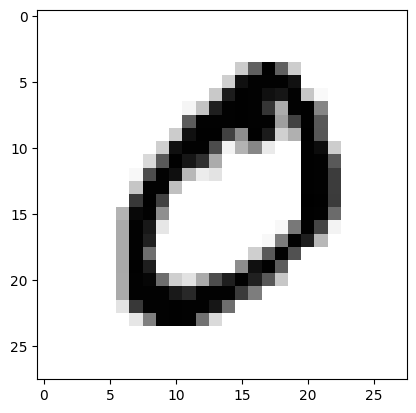

0
torch.Size([1, 28, 28])


In [100]:
#visualize img
img = train[1][0]

plt.imshow(img.squeeze(0),cmap='binary')
plt.show()
print(train[1][1])
print(img.size())

In [101]:
# Parameters

device ='cuda:0' if torch.cuda.is_available() else 'cpu' #check cuda
print(device,'is available!\n')
model = Net().to(device)
#summary(model, input_size=(128, 1, 32, 32))
for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

optimizer = optim.Adam(model.parameters(),betas=(0.9, 0.98), lr=train_info['lr'])
scheduler=lr_scheduler.CosineAnnealingLR(optimizer,5)
criterion= nn.CrossEntropyLoss()



cuda:0 is available!



In [102]:
print(summary(model, input_size=(128, 1, 28, 28)))
with open("model_info.txt", "w") as f:
    f.write(summary(model, input_size=(128, 1, 28, 28)).__repr__())

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [128, 10]                 --
├─Conv2d: 1-1                            [128, 16, 28, 28]         416
├─BatchNorm2d: 1-2                       [128, 16, 28, 28]         32
├─MaxPool2d: 1-3                         [128, 16, 14, 14]         --
├─Conv2d: 1-4                            [128, 32, 14, 14]         12,832
├─BatchNorm2d: 1-5                       [128, 32, 14, 14]         64
├─MaxPool2d: 1-6                         [128, 32, 7, 7]           --
├─Linear: 1-7                            [128, 128]                200,832
├─Dropout: 1-8                           [128, 128]                --
├─Linear: 1-9                            [128, 64]                 8,256
├─Dropout: 1-10                          [128, 64]                 --
├─Linear: 1-11                           [128, 10]                 650
Total params: 223,082
Trainable params: 223,082
Non-trainable params: 0

In [103]:
# Training
#store loss inf
loss={'train_loss':[],'valid_loss':[],'lr':[]}        

#early_stopping
patience=5
earlystop=0
best_loss=float('inf')
epochs = 100


# mlflow set url
mlflow.set_tracking_uri("http://mlflow-web:5000/")

if not mlflow.get_experiment_by_name(train_info['exp_name']):
    mlflow.create_experiment(train_info['exp_name'])

mlflow.set_experiment(train_info['exp_name'])


with mlflow.start_run() as run:
    # para
    mlflow.log_param("data set", "Torchvision-Mnsit")
    mlflow.log_param("Batch Size", train_info['batchSize'])
    if device != 'cpu':
        mlflow.log_param("gpu", "enabled")
    mlflow.log_param("epoch",train_info['epoch'])
    mlflow.log_param("optimizer", train_info['optim'])
    mlflow.log_param("init_lr", train_info['lr'])
    mlflow.log_param("scheduler", train_info['secheduler'])
    mlflow.log_param("loss function", train_info['loss'])
    mlflow.log_artifact("model_info.txt")
    
    for epoch in range(train_info['epoch']):
        #model train
        model.train()
        tmp=[]
        with tqdm(trainLoader,leave=False) as tepoch:
            for inputs, target in tepoch:
                #set tqdm description
                tepoch.set_description(f'TrainEpoch{epoch+1:3d}')
                inputs, target=inputs.to(device), target.to(device)
                # Zero the parameter gradients
                optimizer.zero_grad()
                output = model(inputs)
                crit = criterion(output, target)

                tmp.append(crit.cpu().item())

                crit.backward()
                optimizer.step()
                
                tepoch.set_postfix({'loss':'{0:.3f}'.format(np.average(tmp))})
                
                
            
        scheduler.step()
        mlflow.log_metric("train_loss", np.average(tmp), epoch+1)
        loss['train_loss'].append(np.average(tmp))
        #model valid
        model.eval()
        tmp=[]
        with tqdm(validLoader,leave=False) as vepoch:
            for inputs, target in vepoch:
                vepoch.set_description(f'ValidEpoch{epoch+1:3d}')
                inputs,target=inputs.to(device), target.to(device)

                output=model(inputs)
                crit=criterion1(output,target)

                tmp.append(crit.cpu().item())
                vepoch.set_postfix({'loss':'{0:.3f}'.format(np.average(tmp))})

        

        loss['valid_loss'].append(np.average(tmp))
        loss['lr'].append(scheduler.get_last_lr())
        mlflow.log_metric("valid_loss", np.average(tmp), epoch+1)
        mlflow.log_metric("learning_rate", scheduler.get_last_lr()[0], epoch+1)
        # earlystopping
        cur_loss=np.average(tmp)
        if cur_loss>best_loss:
            earlystop+=1
            if earlystop>= patience:
                print('Early stopping!')
                mlflow.log_param("Early_Stopping_Happened", f'finish in {epoch+1} epochs!' )
                break
        else:
            earlystop=0
            best_loss=cur_loss
        
    mlflow.pytorch.log_model(model, "pytorch-model")
    model_uri = f"runs:/{run.info.run_id}/model-test"
    model_details = mlflow.register_model(model_uri, 'Mnist')
    mlflow.log_param("model save", model_details.source)
    #print(model_details)
        
    print('Finished Training')
    test_acc={}
    classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
    # Test
    correct = 0
    total = 0
    
    model.eval()
    with tqdm(testLoader,leave=True) as tepoch:
        for inputs, labels in tepoch:
            inputs, labels= inputs.to(device), labels.to(device)
            output=model(inputs)
            _, predicted = torch.max(output,1)
            total+=labels.size(0)
            correct += (predicted == labels).sum().item()
            c=(predicted==labels).squeeze()
    
            for i in range(labels.size(0)):
                label=labels[i].item()
                if label not in test_acc:
                    test_acc[label]=[0,0]
                else:
                    test_acc[label][0]+=c[i].item()
                    test_acc[label][1]+=1
    
    
    
    
    for i in range(len(classes)):
        print('Accuracy of %10s : %2d %%' % (classes[i], 100 * test_acc[i][0] / test_acc[i][1]))
    print()
    print('Test Dataset : %d %%' % (100 * correct / total))
    mlflow.log_metric("test accuracy", (100 * correct / total))
# #plot training loss and valid loss

# plt.plot(loss['train_loss'])
# plt.plot(loss['valid_loss'],color='r')
# plt.xlabel('Epoch', fontsize=18)
# plt.ylabel('Loss', fontsize=18)
# plt.legend(["Train Loss", "Valid Loss"],fontsize=12)
# plt.show()

# #plot lr

# plt.plot(loss['lr'])
# plt.xlabel('Epoch', fontsize=18)
# plt.ylabel('Learining Rate', fontsize=18)
# plt.show()

Registered model 'Mnist' already exists. Creating a new version of this model...
2023/09/15 05:23:05 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: Mnist, version 3
Created version '3' of model 'Mnist'.


Finished Training


100%|██████████| 79/79 [00:00<00:00, 110.39it/s]


Accuracy of          0 : 98 %
Accuracy of          1 : 98 %
Accuracy of          2 : 95 %
Accuracy of          3 : 96 %
Accuracy of          4 : 97 %
Accuracy of          5 : 97 %
Accuracy of          6 : 97 %
Accuracy of          7 : 95 %
Accuracy of          8 : 95 %
Accuracy of          9 : 94 %

Test Dataset : 96 %


In [104]:
# pytroch 
scripted_model = torch.jit.script(model)
torch.jit.save(scripted_model, "mnist_save/model.pt")

In [105]:
! pip install minio
from minio import Minio

#prepare config.pbtxt
content = """name: "mnist"
platform: "pytorch_libtorch"
max_batch_size : 256
input [
  {
    name: "input"
    data_type: TYPE_FP32
    dims: [  1, 28, 28 ]

  }
]
output [
  {
    name: "output"
    data_type: TYPE_FP32
    dims: [ 10 ]
  }
]
"""

file_path = "config.pbtxt"
with open(file_path, "w") as file:
    file.write(content)

# minio info ()
minio_info = {'url': 'minio-api:9000',
              'accessKey': 'admin',
              'secretKey': 'admin123',
              'bucket': 'mybucket', }


#model info
model_info = {'name': 'mnist',
              'version': '1', }
              
              

# minio config
clinet = Minio(
    minio_info['url'],
    access_key = minio_info['accessKey'],
    secret_key = minio_info['secretKey'],
    secure = False
)

#found = clinet.bucket_exists(bucket_name)
found = clinet.bucket_exists(minio_info['bucket'])
if not found:
    print(f"no {minio_info['bucket']} in {minio_info['url']}")

else:
    print(f"Bucket {minio_info['bucket']} is existed !")

    
    
    
    # store config.pbtxt
    store_path = f"{model_info['name']}/config.pbtxt"
    clinet.fput_object(
        minio_info['bucket'], store_path, 'config.pbtxt'
    )
    # store model.onnx
    store_path = f"{model_info['name']}/{model_info['version']}/model.pt"
    clinet.fput_object(
        minio_info['bucket'], store_path, 'mnist_save/model.pt'
    )

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Bucket mybucket is existed !
